# Web Shop Orders — Databao example

This notebook shows how to use Databao to answer questions about the web shop orders dataset.



In [1]:
# Imports and DB connection
import duckdb

# Set up the database connection
DB_PATH = "data/web_shop.duckdb"
conn = duckdb.connect(DB_PATH, read_only=True)
print(f"Connected to DuckDB database: {DB_PATH}")

Connected to DuckDB database: data/web_shop.duckdb


In [ ]:
# Databao pip installation
!pip install databao

In [2]:
# import databao
import databao
from databao.configs.llm import LLMConfigDirectory

In [3]:
# Setup llm config for CLOUD model
# llm_config = LLMConfig(name="gpt-4.1-2025-04-14", temperature=0)

# Setup llm config for LOCAL model
# to run it with local model, install ollama https://ollama.com/download/

llm_config = LLMConfigDirectory.QWEN3_8B_OLLAMA
# llm_config = LLMConfig.from_yaml("configs/oss-20b-ollama.yaml")
# llm_config = LLMConfig(name="ollama:gpt-oss:20b", temperature=0)

In [ ]:
# If you want to use cloud model, you need to put your Open AI API token in the env variable

%env OPENAI_API_KEY=

In [4]:
# Opening a databao session. A session manages all databases and Dataframes as well as the context for them.
session = databao.open_session(name="demo", llm_config=llm_config)

# Add your database to the session
session.add_db(conn)

# You can also add dataframes, if you want:

# df_test = pd.read_csv("source-data/webshop_customers.csv")
# session.add_df(df_test, context='just a test dataframe, do not use')

# context is an optional keyword, in which you can provide additional information about the data to the model.
# It can be a string or a path to file.

In [5]:
# Starting a new thread. Thread is a single conversation, like a single chat with chatGPT.
#    - Maintains its own message history (isolated from other threads).
#    - Materializes data and visualizations lazily on demand and caches results per thread.

thread = session.thread()

### 1) Split payments and installments: impact on AOV
Task: How do split payments relate to average order value? Report orders count, average order value, and late-delivery rate by installments bucket (1, 2-6, >6) and by split vs single payment.


In [6]:
thread.ask(
    "How do split payments relate to average order value? Report orders count, average order value,"
    " and late-delivery rate by installments bucket (1, 2-6, >6) and by split vs single payment."
)

In [7]:
df_first_task = thread.df()
df_first_task

======== <THINKING> ========

Okay, let's tackle this user query. The user wants to know how split payments relate to average order value. They want reports on orders count, average order value, and late-delivery rate, grouped by installments bucket (1, 2-6, >6) and by split vs single payment.

First, I need to figure out which tables and columns are relevant. The main tables involved here are likely the order_payments and fct_order_payments, as they contain payment details. The installments are in the payment_installments column. Split payments might refer to payments with more than one installment, so split vs single would be payment_installments = 1 vs >1.

But wait, there's also the payment_type column. The user mentioned split payments, which might be related to payment_type. However, the question is about installments, so maybe split payments here refer to multiple installments. Let me check the schema again. The payment_installments column is in both order_payments and fct_order

,payment_type,installments_bucket,orders_count,avg_order_value,late_delivery_rate
0,single,1,233,735.79,31.76
1,split,2-6,258,1351.36,99.22
2,split,>6,74,2491.94,152.70


In [8]:
df_first_task

,payment_type,installments_bucket,orders_count,avg_order_value,late_delivery_rate
0,single,1,233,735.79,31.76
1,split,2-6,258,1351.36,99.22
2,split,>6,74,2491.94,152.70


In [9]:
thread.plot()

VegaChatResult(text='<explain>\nThe user wants an interesting plot without repetition. The dataset includes categorical variables like `installments_bucket` and `payment_type`, and numerical metrics like `late_delivery_rate`. A bar chart comparing the average `late_delivery_rate` across `installments_bucket` groups is both insightful and visually engaging. Since `installments_bucket` has three distinct categories, aggregating `late_delivery_rate` by these groups will highlight trends. No filters are needed, and the chart avoids redundancy by focusing on a single metric.\n</explain>\n\n<json>\n{\n  "$schema": "https://vega.github.io/schema/vega-lite/v5.json",\n  "mark": "bar",\n  "encoding": {\n    "x": {\n      "field": "installments_bucket",\n      "type": "nominal"\n    },\n    "y": {\n      "aggregate": "mean",\n      "field": "late_delivery_rate",\n      "type": "quantitative"\n    }\n  }\n}\n</json>', meta={'message': AIMessage(content='<explain>\nThe user wants an interesting plot without repetition. The dataset includes categorical variables like `installments_bucket` and `payment_type`, and numerical metrics like `late_delivery_rate`. A bar chart comparing the average `late_delivery_rate` across `installments_bucket` groups is both insightful and visually engaging. Since `installments_bucket` has three distinct categories, aggregating `late_delivery_rate` by these groups will highlight trends. No filters are needed, and the chart avoids redundancy by focusing on a single metric.\n</explain>\n\n<json>\n{\n  "$schema": "https://vega.github.io/schema/vega-lite/v5.json",\n  "mark": "bar",\n  "encoding": {\n    "x": {\n      "field": "installments_bucket",\n      "type": "nominal"\n    },\n    "y": {\n      "aggregate": "mean",\n      "field": "late_delivery_rate",\n      "type": "quantitative"\n    }\n  }\n}\n</json>', additional_kwargs={'reasoning_content': 'Okay, the user wants an interesting plot from the given data and doesn\'t want the same one twice. Let me think about the data first. The dataset has payment_type, installments_bucket, orders_count, avg_order_value, and late_delivery_rate. \n\nFirst, I need to figure out what kind of plot would be interesting. Since there are categorical variables like payment_type and installments_bucket, maybe a bar chart comparing different categories. But the user said not to repeat plots, so I should avoid common ones like simple bar charts.\n\nLooking at the numerical fields, maybe a scatter plot could show relationships. For example, between orders_count and avg_order_value. But that might not be the most interesting. Alternatively, using a box plot for late_delivery_rate across different payment types could show variability.\n\nWait, the user mentioned "interesting," so perhaps a combination. Maybe a grouped bar chart showing orders_count and avg_order_value for each payment type. But that could get cluttered. Alternatively, using a line chart with installments_bucket on the x-axis and late_delivery_rate as the metric, showing trends.\n\nWait, the installments_bucket has three categories: 1, 2-6, >6. Maybe a bar chart comparing late_delivery_rate across these buckets. That could highlight how different installment groups affect late delivery. Also, since late_delivery_rate is a percentage, a bar chart would make sense.\n\nAnother idea: using a scatter plot with payment_type on the x-axis and avg_order_value on the y-axis, colored by installments_bucket. That could show clusters. But the user might prefer a simpler chart.\n\nAlternatively, a heatmap for the relationship between installments_bucket and payment_type, but that might not be straightforward. \n\nWait, the user wants an interesting plot. Maybe a box plot for late_delivery_rate grouped by payment_type, showing the distribution. That could be insightful. Or a bar chart with error bars showing the mean and confidence intervals of late_delivery_rate per payment type.\n\nBut considering the user doesn\'t want the same plo

In [10]:
# You can also see SQL code that was used to produce these results
print(thread.code())

WITH payment_buckets AS (
  SELECT
    order_payments.order_id,
    order_payments.payment_installments,
    CASE WHEN payment_installments > 1 THEN 'split' ELSE 'single' END AS payment_type,
    CASE WHEN payment_installments = 1 THEN '1'
         WHEN payment_installments BETWEEN 2 AND 6 THEN '2-6'
         ELSE '>6'
    END AS installments_bucket,
    order_payments.payment_value,
    orders.order_delivered_customer_date,
    orders.order_estimated_delivery_date
  FROM
    order_payments
  JOIN
    orders
  ON
    order_payments.order_id = orders.order_id
),
order_metrics AS (
  SELECT
    payment_type,
    installments_bucket,
    COUNT(DISTINCT order_id) AS orders_count,
    SUM(payment_value) AS total_payments,
    SUM(CASE WHEN order_delivered_customer_date > order_estimated_delivery_date THEN 1 ELSE 0 END) AS late_orders
  FROM
    payment_buckets
  GROUP BY
    payment_type,
    installments_bucket
)
SELECT
  payment_type,
  installments_bucket,
  orders_count,
  ROUND(total_p

### 2) Late delivery impact on review scores
Task: How does on-time vs late delivery affect review scores? Report the average and median review score and the number of reviewed orders for on‑time vs late deliveries (latest review per order by `review_answer_timestamp`).


In [15]:
thread.ask(
    "Task: How does on-time vs late delivery affect review scores?"
    " Report the average and median review score and the number of reviewed orders for on-time "
    "vs late deliveries (latest review per order by review_answer_timestamp)."
)

In [12]:
df_second_task = thread.df()
df_second_task

======== <THINKING> ========

Okay, let's tackle the user's new question: "How does on-time vs late delivery affect review scores? Report the average and median review score and the number of reviewed orders for on-time vs late deliveries (latest review per order by review_answer_timestamp)."

First, I need to understand what the user is asking. They want to know if there's a correlation between whether an order was delivered on time or late and the review scores given. Specifically, they want the average and median scores for each category, along with the count of orders reviewed.

Looking at the database schema, I need to find the relevant tables. The reviews are in dim_order_reviews and order_reviews, which have review_score, review_answer_timestamp, and order_id. The delivery status would come from the orders table, specifically order_delivered_customer_date and order_estimated_delivery_date. 

Wait, the user mentioned "latest review per order by review_answer_timestamp." So I need

,delivery_status,reviewed_orders,avg_score,median_score
0,late,76,1.70,2.0
1,on_time,89,4.92,5.0


In [13]:
df_second_task

,delivery_status,reviewed_orders,avg_score,median_score
0,late,76,1.70,2.0
1,on_time,89,4.92,5.0


Generated Vega-Lite spec is not valid, but it is still drawable: {
  "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
  "mark": "bar",
  "encoding": {
    "x": {
      "field": "delivery_status",
      "type": "nominal"
    },
    "y": {
      "field": "avg_score",
      "type": "quantitative"
    },
    "y2": {
      "field": "median_score",
      "type": "quantitative"
    }
  }
}


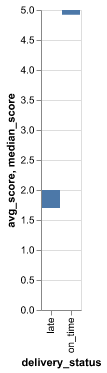

In [14]:
thread.plot()

### 3) Multi-item vs single-item orders: freight and cancellations
Task: How do single‑item vs multi‑item orders differ in total freight paid per order and cancellation rate? Report orders count, average total freight per order, and cancellation rate by item group (single vs multi).

In [ ]:
# you can try to answer it with databao by yourself!


### 4) Customer cohort LTV over time (by first order month)
Task: For each customer cohort, what is the monthly revenue and cumulative LTV over time? Include cohort size and months since cohort start; show cumulative LTV per month per cohort.



### 5) Seller-to-customer lanes: time-in-transit by state pairs
Task: By seller_state → customer_state lanes with at least 20 delivered orders, what are the average and median days in transit? Also report the number of orders per lane and sort by average days in transit.


### 6) Monthly Order Volume and Average Order Value Trends
Task: How do order volumes and average order values change over time? Analyze monthly trends to identify any patterns or seasonality in order activity and spending. Plot the results.

In [ ]:
# Close the database connection
conn.close()
print("Database connection closed successfully!")